In [30]:
import math
import os
import re
from typing import List

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
from tqdm.notebook import tqdm


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)

In [31]:
ts_train_infos = []
ts_test_infos = []
for root, dirs, files in os.walk("../data/ucr_data/UCRArchive_2018/"):
    for name in files:
        if(name.endswith("_TRAIN.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_train_infos.append((ts_name, os.path.join(root,name)))
        elif(name.endswith("_TEST.tsv")):
            path_tmp = os.path.join(root,name)
            ts_name = re.split("/", root)[-1]
            ts_test_infos.append((ts_name, os.path.join(root,name)))

In [32]:
df_ucr_train = pd.DataFrame()
df_ucr_test = pd.DataFrame()

for ts_info in tqdm(ts_train_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_ucr_train = df_ucr_train.append(df_tmp)
    
for ts_info in tqdm(ts_test_infos):
    ts_name = ts_info[0]
    fp = ts_info[1]
    
    df_tmp = pd.read_csv(fp, sep='\t', header=None)
    df_tmp['name'] = ts_name
    df_tmp['no'] = df_tmp.index
    cols = df_tmp.columns.tolist()
    cols = cols[-2:] + cols[:-2]
    df_tmp = df_tmp[cols]
    df_ucr_test = df_ucr_test.append(df_tmp)
    

print("df_train shape: {}".format(df_ucr_train.shape))
print("df_test shape: {}".format(df_ucr_test.shape))

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

df_train shape: (64306, 2847)
df_test shape: (136855, 2847)


In [33]:
df_ucr_test.head()

name  no  0         1         2         3         4         5         6  \
0  Haptics   0  3 -1.288572  0.006059 -2.151010 -1.322679 -0.863004 -1.618088   
1  Haptics   1  4 -1.441763  0.065805 -1.560006 -2.241373 -1.350893 -1.008068   
2  Haptics   2  1 -1.395546  0.131045 -0.255258 -1.429271 -2.205048 -2.095837   
3  Haptics   3  1 -0.900786  0.930432  0.192374 -1.312239 -1.954817 -1.446459   
4  Haptics   4  4 -1.282733  0.153161 -0.106876 -1.176818 -2.036198 -2.147285   

          7  ...  2835  2836  2837  2838  2839  2840  2841  2842  2843  2844  
0 -1.307570  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1 -1.563718  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2 -1.465255  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3 -0.667134  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4 -1.663571  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 2847 columns]

In [34]:
df_dtw = pd.read_csv("../data/df_dtw_comp.csv")

In [35]:
df_dtw.head()

ts_1  no_1  class_1                 ts_2  no_2  class_2  \
0            ArrowHead   153        2            ArrowHead     8        2   
1            ArrowHead   154        2            ArrowHead    17        2   
2  InsectWingbeatSound    98        8  InsectWingbeatSound   175        7   
3  InsectWingbeatSound   174        5  InsectWingbeatSound   170        9   
4  InsectWingbeatSound   194        4  InsectWingbeatSound    61        4   

   min_dtw_dist  
0     11.453478  
1      7.934686  
2     24.418690  
3     32.303582  
4     16.177841

## thoughts

- consider only the ones where the result was found in the same category (because that seems more reasonable to the class)
- check percentage that match vs the ones that  don't

In [36]:
df_dtw_sub = df_dtw[df_dtw['ts_1']==df_dtw['ts_2']]

In [37]:
df_dtw['ts_1'].nunique()

128

In [38]:
df_dtw.shape

(1420, 7)

In [39]:
df_dtw_sub.shape

(889, 7)

In [40]:
df_dtw_cls = df_dtw[(df_dtw['ts_1']==df_dtw['ts_2']) &
       (df_dtw['class_1']==df_dtw['class_2'])]

In [41]:
df_dtw_cls

ts_1  no_1  class_1                 ts_2  no_2  class_2  \
0               ArrowHead   153        2            ArrowHead     8        2   
1               ArrowHead   154        2            ArrowHead    17        2   
4     InsectWingbeatSound   194        4  InsectWingbeatSound    61        4   
6     InsectWingbeatSound  1138        1  InsectWingbeatSound   212        1   
8     InsectWingbeatSound  1577        9  InsectWingbeatSound    10        9   
...                   ...   ...      ...                  ...   ...      ...   
1414                PLAID   505        9                PLAID   507        9   
1415                PLAID   511        9                PLAID   513        9   
1417               Mallat    50        6               Mallat    44        6   
1418               Mallat   817        7               Mallat    28        7   
1419               Mallat  1223        1               Mallat    34        1   

      min_dtw_dist  
0        11.453478  
1         7.934686  
4        16.177841  
6        22.607338  
8        25.816940  
...            ...  
1414   1220.501439  
1415     24.602363  
1417     52.752090  
1418     46.783404  
1419     40.734581  

[658 rows x 7 columns]

#### results in the same data category

In [42]:
df_dtw_cat = df_dtw[(df_dtw['ts_1']==df_dtw['ts_2'])]
df_dtw_cat['ts_1'].nunique()

112

In [43]:
cats = list(set(df_dtw['ts_1'].unique())-set(df_dtw_cat['ts_1'].unique()))

In [ ]:
fig, axs = plt.subplots(16,2,figsize=(20,20))
fig.tight_layout()

for i in tqdm(range(len(cats))):
    cat = cats[i]
    df_train_tmp = df_ucr_train[df_ucr_train['name']==cat]
    df_test_tmp = df_ucr_test[df_ucr_test['name']==cat]
    
    for key, row in df_train_tmp.iterrows():
        name = row.iloc[0]+" - "+str(row.iloc[1])+" - "+str(row.iloc[2])
        ar = np.array(row.iloc[3:].dropna())
        n = ar.size
        x = np.linspace(1,n,n)
        sns.lineplot(x=x, y=ar, label=name, ax=axs.flatten()[i])
        
    for key, row in df_test_tmp.iterrows():
        name = row.iloc[0]+" - "+str(row.iloc[1])+" - "+str(row.iloc[2])
        ar = np.array(row.iloc[3:].dropna())
        n = ar.size
        x = np.linspace(1,n,n)
        sns.lineplot(x=x, y=ar, label=name, ax=axs.flatten()[i+1])  
        

#### results in the same with same class from results with same category

In [32]:
658/889

0.7401574803149606

### FFT-based matches

In [45]:
df_fft = pd.read_csv("../data/df_ucr_min_delta.csv")

In [46]:
df_T = df_fft.T

In [47]:
df_T.head(10)

0        1        2         3         4         5      \
ts_1           ACSF1    ACSF1    ACSF1     ACSF1     ACSF1     ACSF1   
no_1               0        0        0         0         0         0   
class_1            9        9        9         9         9         9   
ts_2           ACSF1    ACSF1    ACSF1     ACSF1     ACSF1     ACSF1   
no_2               0       35       22         8         8         5   
class_2            0       35       22         8         8         5   
type         Hamming  Hamming  Hamming   Hamming   Hamming   Hamming   
match_score    11111    11111    11111     11111     11111     11111   
min_kpi          d_m   d_mean    d_std     d_q25     d_q50     d_q75   
value            0.0      0.0      0.0  0.003545  0.003484  0.016093   

                6         7      8       9      ...     30542     30543  \
ts_1            ACSF1     ACSF1  ACSF1   ACSF1  ...      Yoga      Yoga   
no_1                0         0      0       0  ...      2690      2690   
class_1             9         9      9       9  ...         2         2   
ts_2            ACSF1     ACSF1  ACSF1   ACSF1  ...      Yoga      Yoga   
no_2               19        35      0      35  ...        64       250   
class_2            19        35      0      35  ...        64       250   
type          Hamming   Hamming  Welch   Welch  ...     Welch     Welch   
match_score     11111     11111  11111   11111  ...     11111     11111   
min_kpi         d_min     d_max    d_m  d_mean  ...     d_min     d_max   
value        0.005995  0.000793    0.0     0.0  ...  0.007975  0.000541   

             30544   30545  30546     30547     30548     30549     30550  \
ts_1          Yoga    Yoga   Yoga      Yoga      Yoga      Yoga      Yoga   
no_1          2690    2690   2690      2690      2690      2690      2690   
class_1          2       2      2         2         2         2         2   
ts_2          Yoga    Yoga   Yoga      Yoga      Yoga      Yoga      Yoga   
no_2             2     252    142       107       102        78       249   
class_2          2     252    142       107       102        78       249   
type           fft     fft    fft       fft       fft       fft       fft   
match_score  11111   11111  11111     11111     11111     11111     11111   
min_kpi        d_m  d_mean  d_std     d_q25     d_q50     d_q75     d_min   
value          0.0     0.0    0.0  0.011248  0.007735  0.008277  0.120939   

                30551  
ts_1             Yoga  
no_1             2690  
class_1             2  
ts_2             Yoga  
no_2              142  
class_2           142  
type              fft  
match_score     11111  
min_kpi         d_max  
value        0.006929  

[10 rows x 30552 columns]

In [48]:
fft_types = df_fft['type'].unique()
kpis = df_fft['min_kpi'].unique()
print(f"FFT types: {fft_types}")
print(f"KPIs: {kpis}")

FFT types: ['Hamming' 'Welch' 'fft']
KPIs: ['d_m' 'd_mean' 'd_std' 'd_q25' 'd_q50' 'd_q75' 'd_min' 'd_max']


### same category results for FFT

In [49]:
df_fft_res  = df_fft[(df_fft['ts_1']==df_fft['ts_2'])]

In [50]:
df_fft_agg = df_fft_res.groupby(['type','min_kpi']).count()['value'].reset_index().sort_values('value', ascending=False)
df_fft_agg.columns = ['type','kpi','value']
df_fft_agg              

type     kpi  value
15    Welch   d_std    823
21      fft   d_q50    815
20      fft   d_q25    810
3   Hamming   d_min    807
7   Hamming   d_std    807
19      fft   d_min    803
5   Hamming   d_q50    799
1   Hamming   d_max    797
17      fft   d_max    797
22      fft   d_q75    792
16      fft     d_m    792
6   Hamming   d_q75    789
4   Hamming   d_q25    789
23      fft   d_std    789
2   Hamming  d_mean    779
11    Welch   d_min    773
18      fft  d_mean    766
0   Hamming     d_m    755
8     Welch     d_m    742
12    Welch   d_q25    740
9     Welch   d_max    739
14    Welch   d_q75    729
13    Welch   d_q50    725
10    Welch  d_mean    679

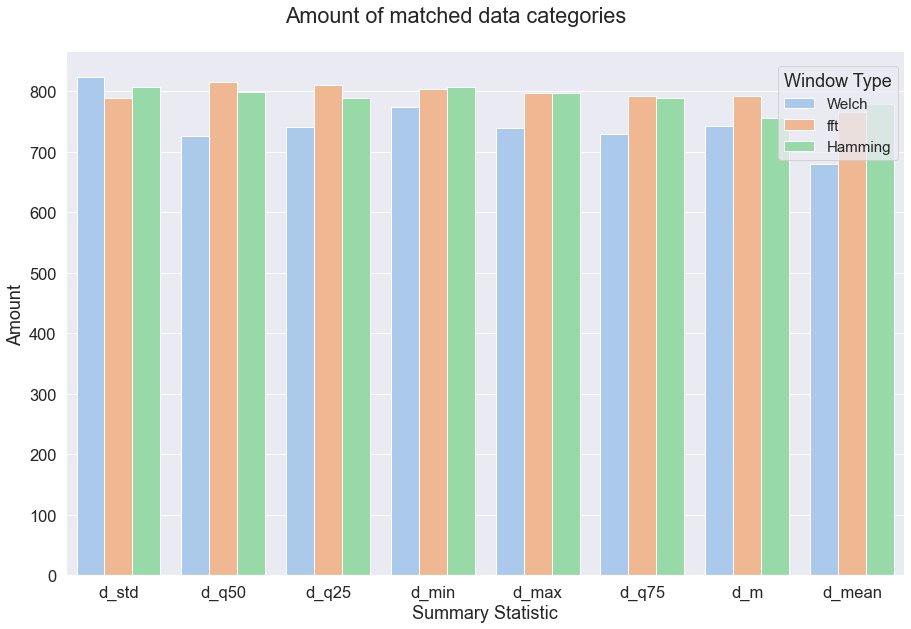

In [51]:
cmp = sns.color_palette("pastel", 9)
sns.set_theme(font_scale=1.5, palette=cmp)

g = sns.catplot(data=df_fft_agg, x='kpi', y='value', hue='type', kind='bar', legend=False);
g.fig.set_size_inches(13,9)
g.set_xlabels("Summary Statistic")
g.set_ylabels("Amount")
g.fig.suptitle("Amount of matched data categories")
g.fig.set_tight_layout('tight')
g.fig.legend(fontsize = 15, \
               bbox_to_anchor= (.98, .9), \
               title="Window Type", \
               title_fontsize = 18);
g.fig.savefig("../img/fft_matched_cats.png")

### same class results for the series

In [52]:
df_fft_clsm  = df_fft[(df_fft['ts_1']==df_fft['ts_2']) &
                     (df_fft['class_1']==df_fft['class_2'])]
df_fft_clsm.shape

(295, 10)

In [53]:
df_fft_clsm.head()

ts_1  no_1  class_1       ts_2  no_2  class_2     type  \
15        ACSF1     0        9      ACSF1     9        9    Welch   
104       ACSF1    35        0      ACSF1     0        0    Welch   
1192  ArrowHead    12        0  ArrowHead     0        0    Welch   
1198  ArrowHead    12        0  ArrowHead     0        0    Welch   
1224  ArrowHead    23        0  ArrowHead     0        0  Hamming   

      match_score min_kpi     value  
15          11111   d_max  0.000233  
104         11111     d_m  0.000000  
1192        11111     d_m  0.000000  
1198        11111   d_min  0.007951  
1224        11111     d_m  0.000000

In [54]:
df_cls_agg = df_fft_clsm.groupby(['type','min_kpi']).count()['value'].reset_index().sort_values('value', ascending=False)
df_cls_agg.columns = ['type','kpi','value']
df_cls_agg              

type     kpi  value
0   Hamming     d_m     41
8     Welch     d_m     39
16      fft     d_m     28
4   Hamming   d_q25     15
7   Hamming   d_std     13
15    Welch   d_std     13
2   Hamming  d_mean     12
3   Hamming   d_min     10
20      fft   d_q25     10
9     Welch   d_max     10
14    Welch   d_q75      9
22      fft   d_q75      9
18      fft  d_mean      9
23      fft   d_std      9
11    Welch   d_min      8
19      fft   d_min      8
6   Hamming   d_q75      8
12    Welch   d_q25      8
13    Welch   d_q50      7
5   Hamming   d_q50      7
1   Hamming   d_max      6
17      fft   d_max      6
10    Welch  d_mean      5
21      fft   d_q50      5

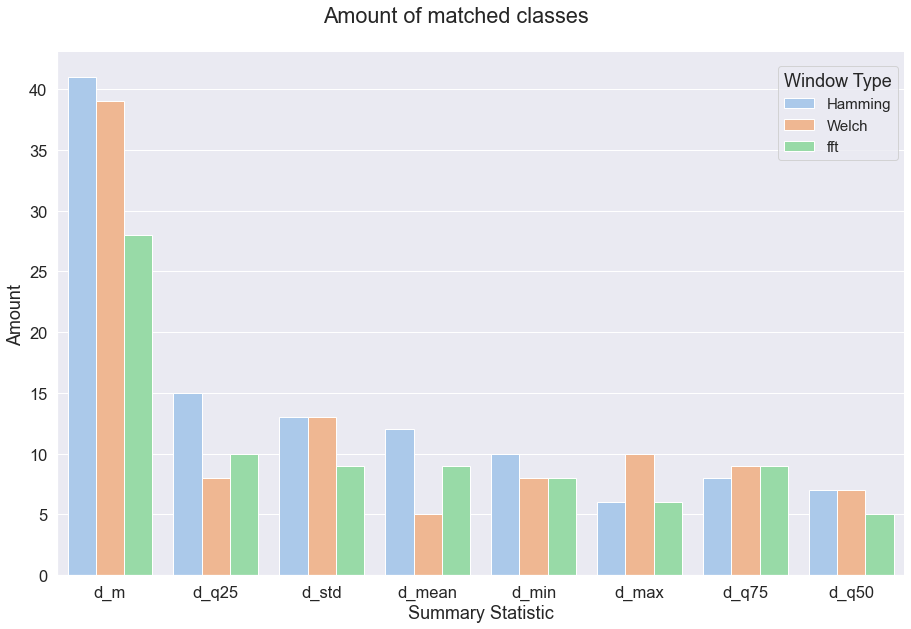

In [55]:
cmp = sns.color_palette("pastel", 9)
sns.set_theme(font_scale=1.5, palette=cmp)

g = sns.catplot(data=df_cls_agg, x='kpi', y='value', hue='type', kind='bar', legend=False);
g.fig.set_size_inches(13,9)
g.set_xlabels("Summary Statistic")
g.set_ylabels("Amount")
g.fig.suptitle("Amount of matched classes")
g.fig.set_tight_layout('tight')
g.fig.legend(fontsize = 15, \
               bbox_to_anchor= (.98, .9), \
               title="Window Type", \
               title_fontsize = 18);
g.fig.savefig("../img/fft_matched_cls.png")

In [ ]:
df_t